# Template for hand-in on private clustering

Advanced Topics in Machine Learning, U. Copenhagen, fall 2023

Created by Rasmus Pagh

# Fetch and load dataset

The dataset consists of 3414 embedding vectors for first names from the GloVe dataset. Each vector is a 100-dimensional unit vector.

In [5]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

!curl -s https://rasmuspagh.net/data/glove.twitter.27B.100d.names.pickle -O
input_file = "glove.twitter.27B.100d.names.pickle"
with open(input_file, 'rb') as f:
    embedding = pickle.load(f)
names = list(embedding.keys())
points = np.array([ embedding[x] for x in names ])
n, d = points.shape

# Non-private implementation of cost computation and k-means algorithm

In [6]:
def compute_cost(points, centers):
    distances_squared = np.sum((points - centers[:,np.newaxis])**2, axis=-1)
    return np.mean(np.min(distances_squared, axis=0))


def k_means(points, k, t):
    initial_assignment = np.random.choice(range(k), n)
    cluster_indexes = [ (initial_assignment == i) for i in range(k) ]
    cluster_sizes = [ cluster_indexes[i].sum() for i in range(k) ]

    for l in range(t):
        cluster_sums = [ np.sum(points[cluster_indexes[i]], axis=0) for i in range(k) ]
        centers = np.array([ cluster_sums[i] / max(1, cluster_sizes[i]) for i in range(k) ])
        distances_squared = np.sum((points - centers[:,np.newaxis])**2, axis=-1)
        assignment = np.argmin(distances_squared, axis=0)
        cluster_indexes = [ (assignment == i) for i in range(k) ]
        cluster_sizes = [ cluster_indexes[i].sum() for i in range(k) ]

    return centers

# Private k-means implementation
def private_k_means(points, k, t, rho):
    # Compute sigma and sigma' from the given privacy parameter rho (Found in report)
    sigma_squared = 2 * t / rho
    sigma_prime_squared = t / rho
    sigma = np.sqrt(sigma_squared)
    sigma_prime = np.sqrt(sigma_prime_squared)

    # Copied directly from k_means
    initial_assignment = np.random.choice(range(k), n)
    cluster_indexes = [ (initial_assignment == i) for i in range(k) ]
    cluster_sizes = [ cluster_indexes[i].sum() for i in range(k) ]

    for l in range(t):
        # Add noise to the cluster sums
        cluster_sums = [ np.sum(points[cluster_indexes[i]], axis=0) + np.random.normal(0, sigma, d) for i in range(k) ]
        # Add noise to the cluster sizes
        noisy_cluster_sizes = [ max(1, cluster_sizes[i] + np.random.normal(0, sigma_prime)) for i in range(k) ]
        # Compute new centers
        centers = np.array([ cluster_sums[i] / noisy_cluster_sizes[i] for i in range(k) ])

        # Same As k-Means
        distances_squared = np.sum((points - centers[:,np.newaxis])**2, axis=-1)
        assignment = np.argmin(distances_squared, axis=0)
        cluster_indexes = [ (assignment == i) for i in range(k) ]
        cluster_sizes = [ cluster_indexes[i].sum() for i in range(k) ]

    return centers

# Plot cost as function of number of iterations

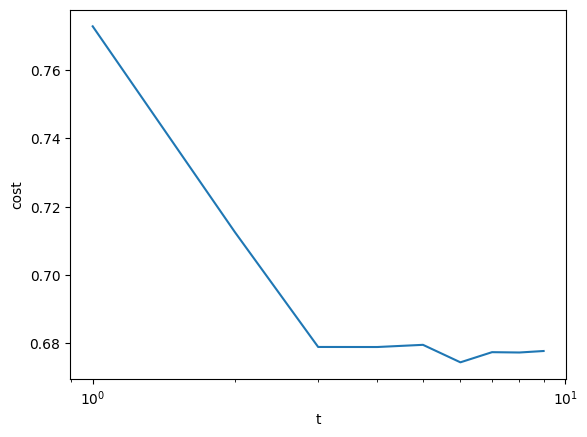

In [7]:
k = 5 # Number of clusters

t_range = range(1,10)
costs = []
for t in t_range: # number of iterations
    centers = k_means(points, k, t)
    costs.append(compute_cost(points, centers))

fig, ax = plt.subplots()
ax.set_xlabel('t')
ax.set_ylabel('cost')
ax.plot(t_range, costs)
plt.xscale('log')
plt.show()


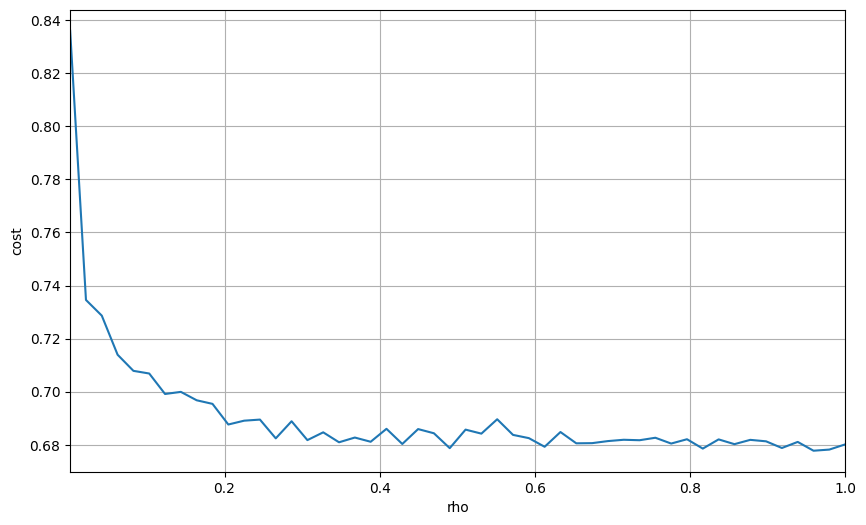

In [8]:
k = 5  # Number of clusters
t = 5  # Number of iterations

rho_values = np.linspace(0.001, 1, 50)  # Range to test
costs = [] # Storing costs

for rho in rho_values:
    centers = private_k_means(points, k, t, rho)
    costs.append(compute_cost(points, centers))

# Plot the cost as a function of rho
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlabel('rho')
ax.set_ylabel('cost')
ax.plot(rho_values, costs)
plt.grid()
ax.set_xlim([rho_values[0], rho_values[-1]])
plt.show()